### Import necessary libraries. 

In [1]:
# Data processing modual
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.impute import SimpleImputer

# Visualisation modual
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

### Read data file

In [2]:
#sets the maximum number of columns and rows displayed when a frame is pretty-printed
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

In [3]:
d = pd.read_csv('bankruptcy.csv')
#Replace the categorical column (class) values into binary
d['class']=pd.Categorical(d['class'].replace({"b'0'" : 0, "b'1'":1}))
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10503 entries, 0 to 10502
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Attr1   10503 non-null  float64 
 1   Attr2   10503 non-null  float64 
 2   Attr3   10503 non-null  float64 
 3   Attr4   10485 non-null  float64 
 4   Attr5   10478 non-null  float64 
 5   Attr6   10503 non-null  float64 
 6   Attr7   10503 non-null  float64 
 7   Attr8   10489 non-null  float64 
 8   Attr9   10500 non-null  float64 
 9   Attr10  10503 non-null  float64 
 10  Attr11  10503 non-null  float64 
 11  Attr12  10485 non-null  float64 
 12  Attr13  10460 non-null  float64 
 13  Attr14  10503 non-null  float64 
 14  Attr15  10495 non-null  float64 
 15  Attr16  10489 non-null  float64 
 16  Attr17  10489 non-null  float64 
 17  Attr18  10503 non-null  float64 
 18  Attr19  10460 non-null  float64 
 19  Attr20  10460 non-null  float64 
 20  Attr21  9696 non-null   float64 
 21  Attr22  1050

In [4]:
# Change the class variable from categorical to integer
d['class']= pd.Categorical(d['class']).codes

In [5]:
def show_Null_plot(dataset):
    dataset.isnull().any() #check whether it is NULL for each row
    msno.matrix(dataset, labels = True, sparkline = False, figsize=(35,20), fontsize = 18)

Attr37    4736
Attr21     807
Attr27     715
Attr60     592
Attr45     591
Attr28     228
Attr53     228
Attr54     228
Attr64     228
Attr24     227
Attr41     202
Attr32     101
Attr47      86
Attr52      86
Attr30      43
Attr20      43
Attr49      43
Attr23      43
Attr56      43
Attr39      43
dtype: int64


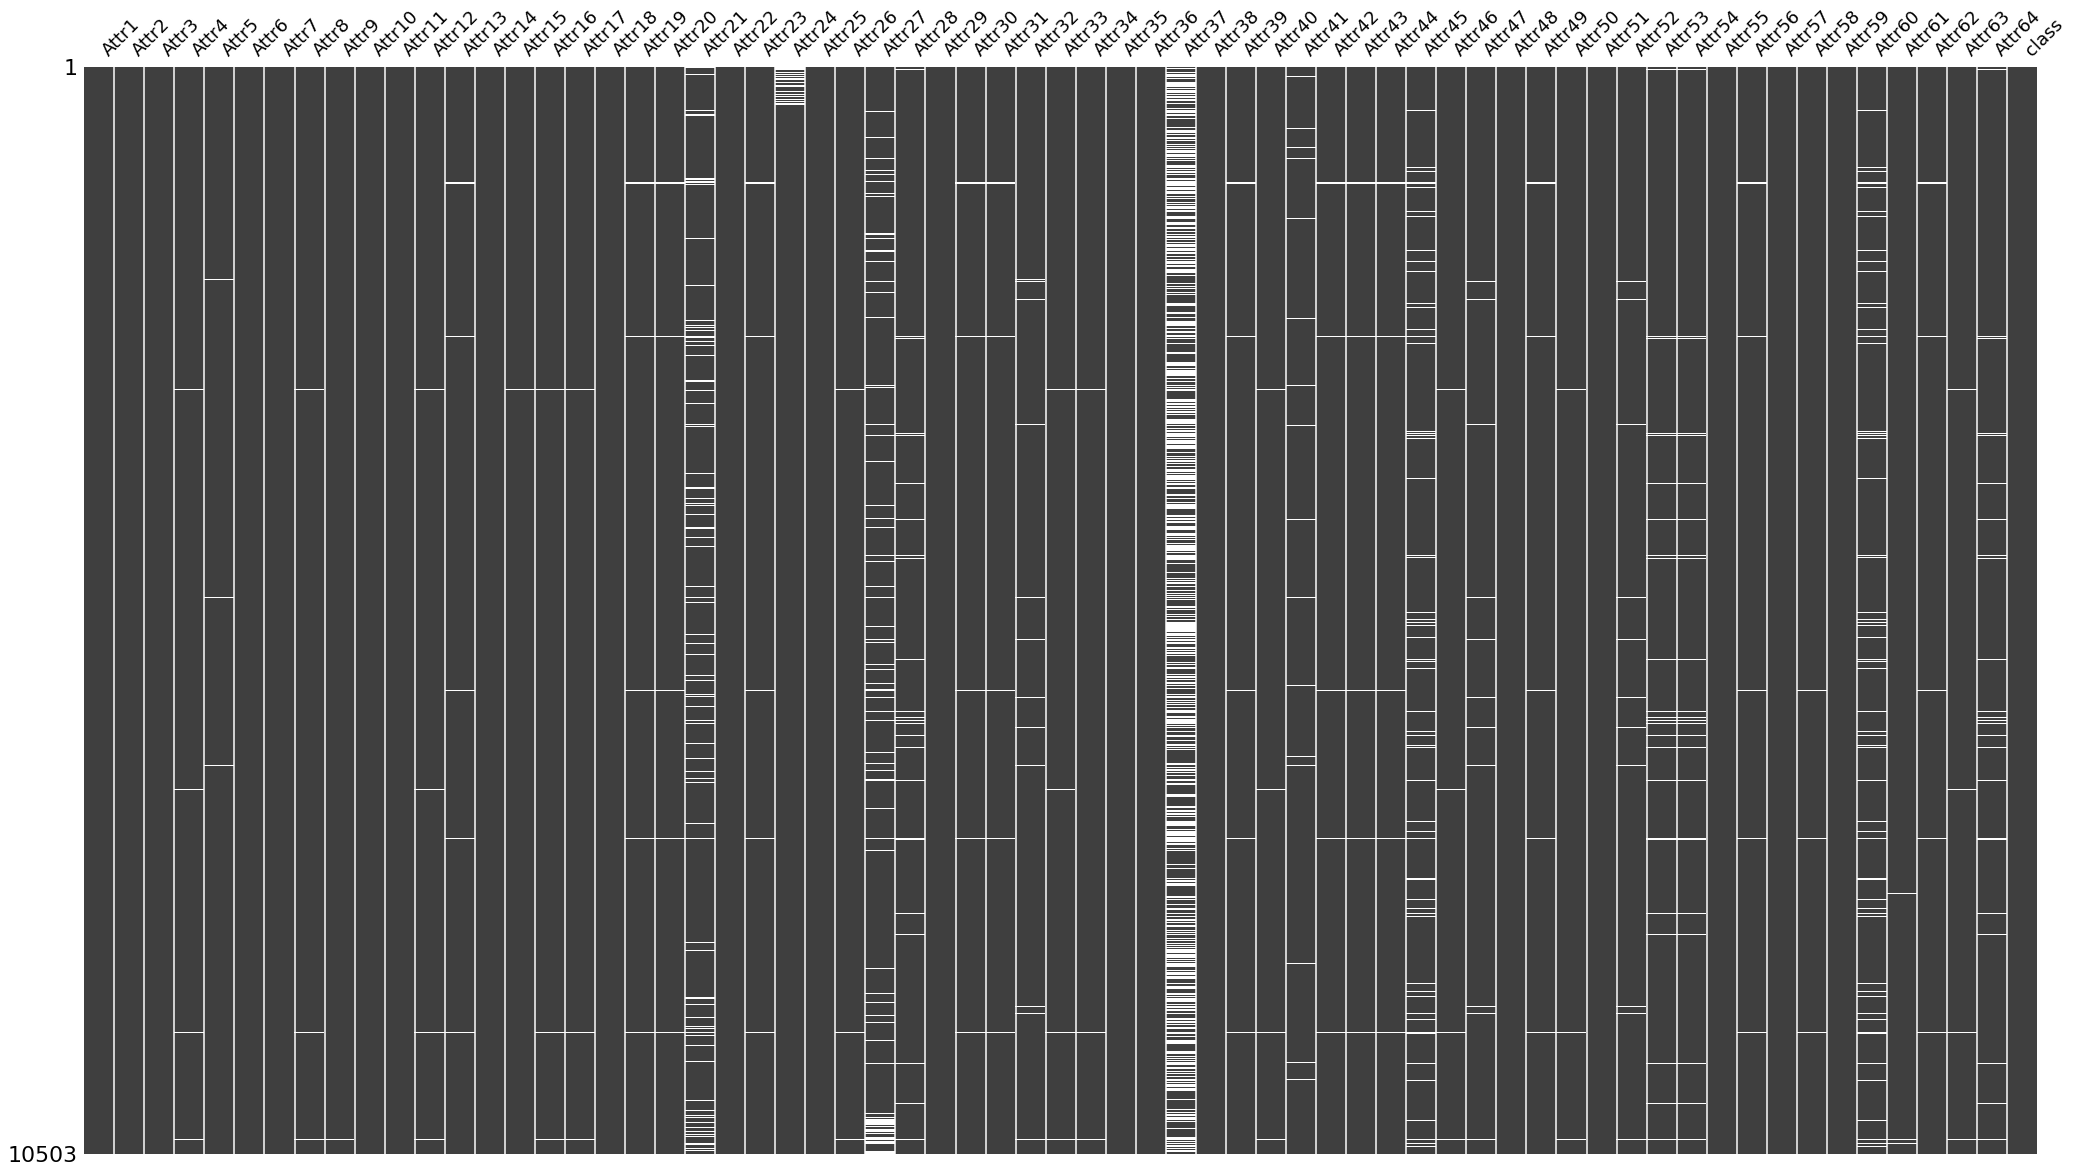

In [6]:
# Using opened-source to show the plot
show_Null_plot(d)

# Find top 20 columns with most null values
print(d.isnull().sum().sort_values(ascending=False).head(20))

<BarContainer object of 65 artists>

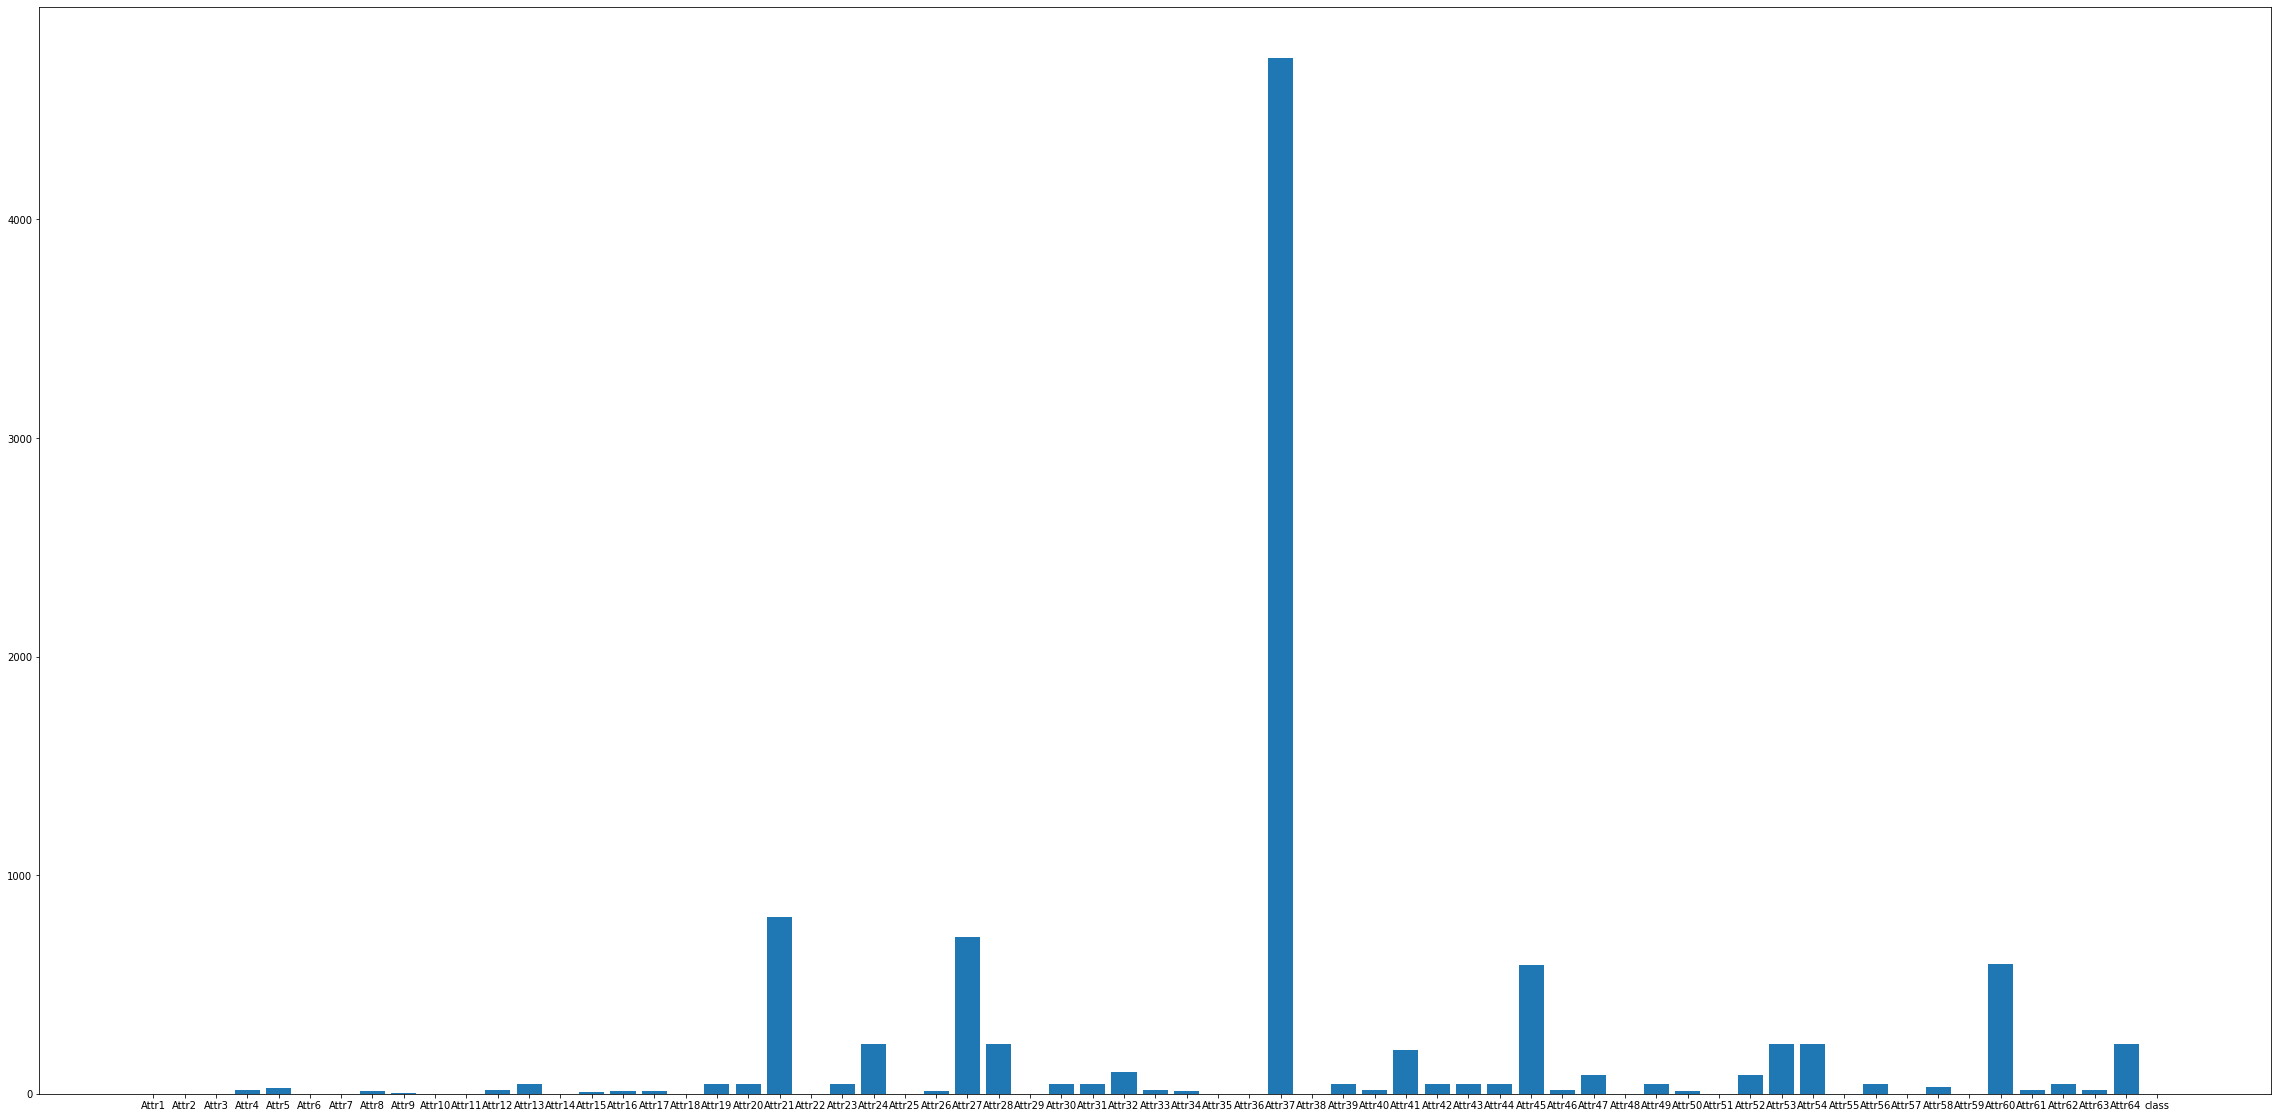

In [7]:
#replace the null values with 'nan'
d = d.replace('', np.nan)
nan_columns = []
nan_values = []
#count the number of  nan values in Dataset and plot a bargraph
for column in d.columns:
    nan_columns.append(column)
    nan_values.append(d[column].isnull().sum())

fig, ax = plt.subplots(figsize=(40,20))
plt.bar(nan_columns, nan_values)

Column Attr37 contains the highest number of "Nan" values and data imputation on the column will nto be useful. Remove the column and plot the bar graph again

Attr21    807
Attr27    715
Attr60    592
Attr45    591
Attr64    228
Attr28    228
Attr54    228
Attr53    228
Attr24    227
Attr41    202
Attr32    101
Attr47     86
Attr52     86
Attr56     43
Attr23     43
Attr49     43
Attr19     43
Attr20     43
Attr39     43
Attr31     43
dtype: int64


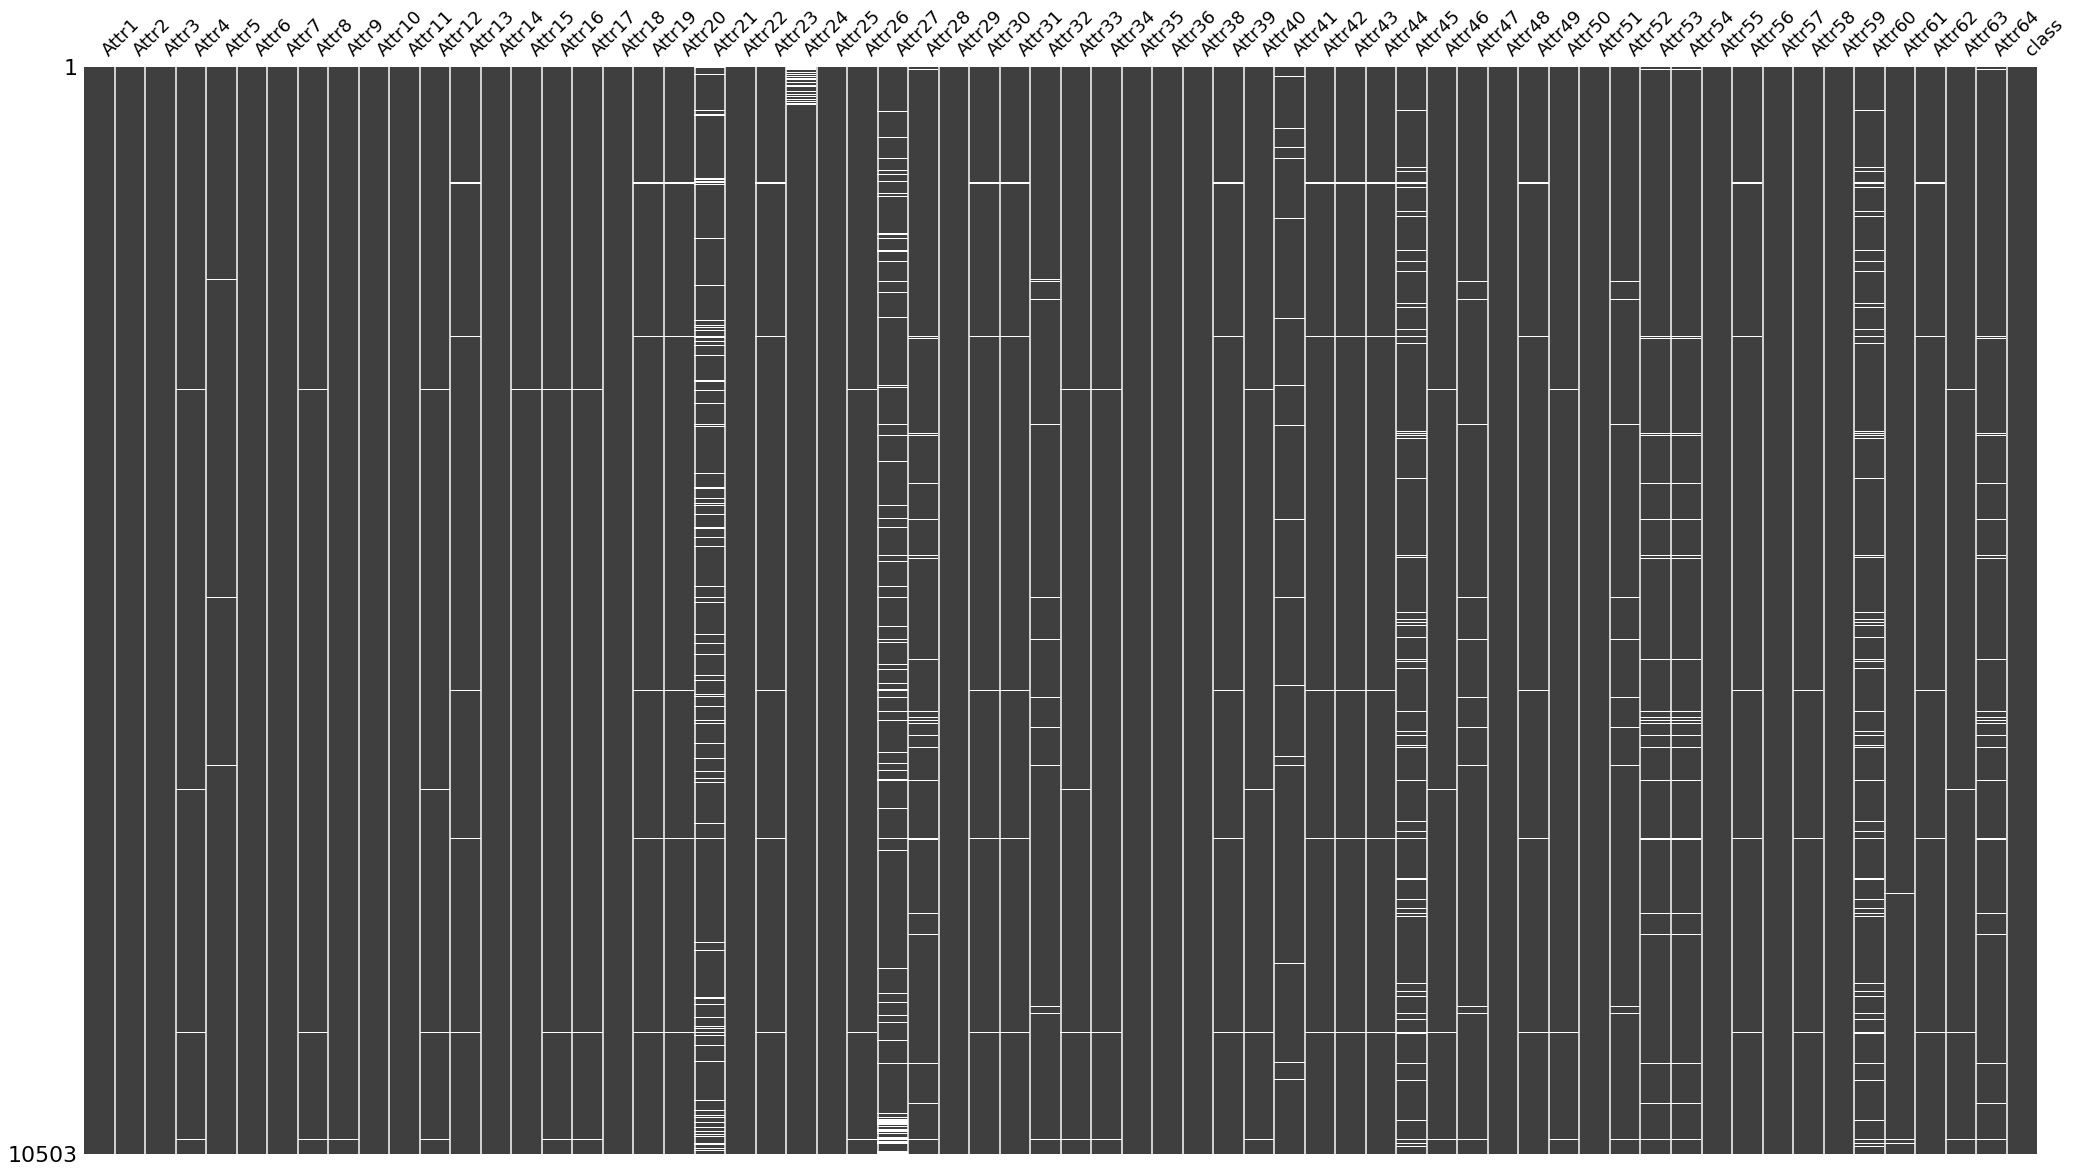

In [8]:
# Delete the column with highest number of nan values ie Column Attr37
d = d.drop(columns = ['Attr37'])
# Find 20 columns with most nan values
print(d.isnull().sum().sort_values(ascending=False).head(20))

show_Null_plot(d)

<BarContainer object of 64 artists>

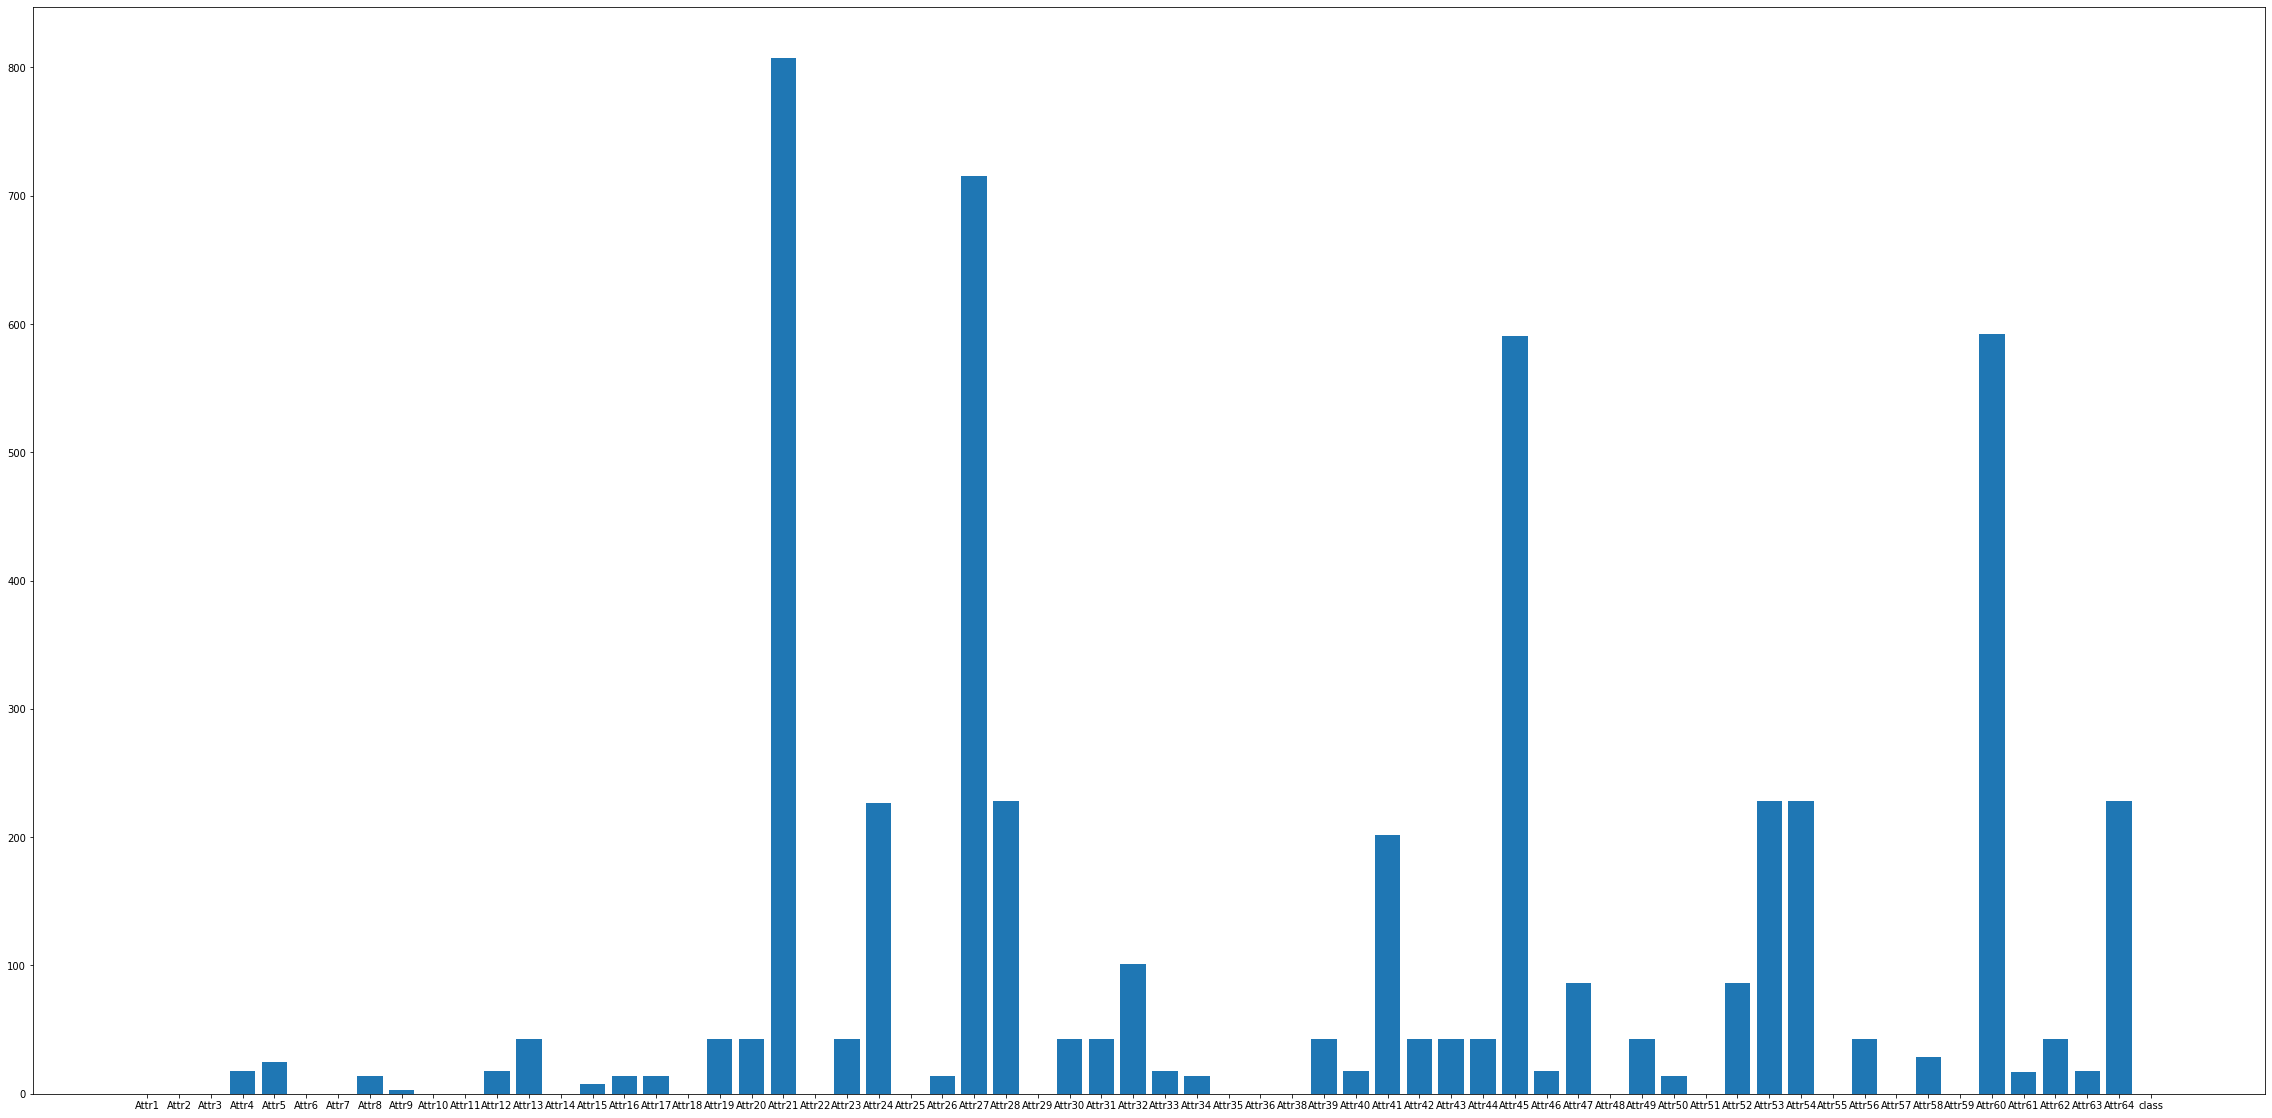

In [9]:
# Plot the null values graph after removing the Attr37 column
nan_columns = []
nan_values  = []

for column in d.columns:
    nan_columns.append(column)
    nan_values.append(d[column].isnull().sum())

fig, ax = plt.subplots(figsize=(40,20))
plt.bar(nan_columns, nan_values)

## Outlier detection & Treatment
Outliers are observations that are far away from the other data points in a random sample of a population. We often want to make assumptions about a specific population. Extreme values can have a significant impact on conclusions drawn from data.

<b>Commonly used methods for detection of outliers is:</b> 
1. Tukey’s box plot method-
    Tukey distinguishes between possible and probable outliers. A possible outlier is located between the inner and the outer       fence, whereas a probable outlier is located outside the outer fence.
2. z-score method-
    For each observation (Xn), it is measured how many standard deviations the data point is away from its mean (X̄).
3. Median Absolute Deviation method-
    Replaces the mean and standard deviation with more robust statistics, like the median and median absolute deviation. The       median absolute deviation is defined as:

In [10]:
# Method for outlier detection via Inter-quartile range method: 
def outlier_detection(x, scale):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - scale * IQR 
    upper = Q3 + scale * IQR  
    outliers = ((x<lower)| (x>upper)).sum()
    total_length = len(x.index)
    percent_outlier = (outliers * 100 / total_length).round(3)
    print(x.name, "\tTotal outliers is: ", outliers,"\t", "\t Percentage Outliers: ", percent_outlier )    

In [11]:
# check number of Outliers in all columns
# Scale is 1.5 (Popular)
scale = 1.5
for column in d:
    outlier_detection(d[column], scale)

Attr1 	Total outliers is:  1266 	 	 Percentage Outliers:  12.054
Attr2 	Total outliers is:  290 	 	 Percentage Outliers:  2.761
Attr3 	Total outliers is:  271 	 	 Percentage Outliers:  2.58
Attr4 	Total outliers is:  1113 	 	 Percentage Outliers:  10.597
Attr5 	Total outliers is:  1562 	 	 Percentage Outliers:  14.872
Attr6 	Total outliers is:  3170 	 	 Percentage Outliers:  30.182
Attr7 	Total outliers is:  1139 	 	 Percentage Outliers:  10.845
Attr8 	Total outliers is:  1146 	 	 Percentage Outliers:  10.911
Attr9 	Total outliers is:  726 	 	 Percentage Outliers:  6.912
Attr10 	Total outliers is:  305 	 	 Percentage Outliers:  2.904
Attr11 	Total outliers is:  1012 	 	 Percentage Outliers:  9.635
Attr12 	Total outliers is:  1516 	 	 Percentage Outliers:  14.434
Attr13 	Total outliers is:  1100 	 	 Percentage Outliers:  10.473
Attr14 	Total outliers is:  1139 	 	 Percentage Outliers:  10.845
Attr15 	Total outliers is:  1799 	 	 Percentage Outliers:  17.128
Attr16 	Total outliers is:  1

<b>For the treatement of outliers there are several methods:</b>
1. Quantile-based Flooring and Capping:
    Here points below 10th percentile are replaced with 10th percentile values
    and  points above 90th percentile are replaced with 90th percentile values.
    
2. Trimming:
      We completely remove data points that are outliers. This changes the total number of data rows present largely for our         bankruptcy data
    
3. IQR Score:
    The rule of thumb is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed
    
4. Log Transformation:
    Each cell could be transformed to a new value by formulating logarithmic, square, square root etc. But since we have           negative values too we cannot use this method
    
5. Replacing Outliers with Median Values:
    We calculate the median and aassign those values to the upper and lower datapoints

In [27]:
# Outlier treatment (Replacing Outliers with Median Values)
df_median_treated = d.copy()
def outlier_treatment(attr,threshold):
    Q1 = attr.quantile(0.25)
    Q2 = attr.quantile(0.50)
    Q3 = attr.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - threshold * IQR 
    upper = Q3 + threshold * IQR 
    if (attr.name != 'class'):
        df_median_treated[attr.name] = np.where((df_median_treated[attr.name]>upper)|(df_median_treated[attr.name]<lower), Q2 , df_median_treated[attr.name]) 

In [28]:
for column in df_median_treated:
    outlier_treatment(df_median_treated[column], scale)
    
df_median_treated.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10485.000000,10478.000000,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,10503.000000,10485.000000,10460.000000,10503.000000,10495.000000,10489.000000,10489.000000,10503.000000,10460.000000,10460.000000,9696.000000,10503.000000,10460.000000,10276.000000,10503.000000,10489.000000,9788.000000,10275.000000,10503.000000,10460.000000,10460.000000,10402.000000,10485.000000,10489.000000,10503.000000,10503.000000,10503.000000,10460.000000,10485.000000,10301.000000,10460.000000,10460.000000,10460.000000,9912.000000,10485.000000,10417.000000,10503.000000,10460.000000,10489.000000,10503.000000,10417.000000,10275.000000,10275.000000,10503.000000,10460.000000,10503.000000,10474.000000,10503.000000,9911.000000,10486.000000,10460.000000,10485.000000,10275.000000,10503.000000
mean,0.055132,0.471526,0.226989,1.797780,2.052617,0.008607,0.064839,1.379031,1.416955,0.512450,0.079971,0.201046,0.074509,0.064850,983.256606,0.278934,2.426973,0.064848,0.041018,38.388497,0.944285,0.068338,0.035532,0.185714,0.384008,0.252794,1.380672,0.574669,3.922662,0.230334,0.048461,83.343497,5.106519,2.499953,0.067020,1.673840,0.606513,0.043871,0.304956,0.093779,0.044558,101.126796,56.178645,0.331790,1.182433,41.497228,0.023854,0.014484,1.366370,0.355045,0.227819,1.281415,1.473313,1401.824380,0.060645,0.125739,0.943527,0.066428,11.426956,7.003060,76.024286,5.592025,4.759630,0.047129
std,0.087436,0.270816,0.287738,1.140869,70.153633,0.040741,0.100878,1.401404,0.712702,0.268852,0.107252,0.366147,0.077457,0.100873,1293.723823,0.368354,1.436500,0.100874,0.059989,30.815519,0.221717,0.101049,0.052322,0.252807,0.305054,0.335255,2.542282,0.884818,0.778408,0.232568,0.066150,52.247536,3.271502,2.570040,0.101575,0.887692,0.232288,0.062112,0.376925,0.106460,0.062394,50.268383,30.712851,0.593879,0.844468,33.968359,0.105885,0.066650,0.915897,0.225436,0.142702,0.935266,0.856059,2559.090079,0.085951,0.175138,0.082599,0.132909,8.651786,3.713534,47.596773,3.551275,4.099627,0.211926
min,-0.183050,0.000000,-0.583670,0.002080,-213.940000,-0.108380,-0.207790,-2.081800,-0.000084,-0.344980,-0.216090,-0.838260,-0.148340,-0.207790,-2801.200000,-0.813470,-0.043411,-0.207790,-0.126850,-0.001439,0.333360,-0.218350,-0.111910,-0.522850,-0.577780,-0.744590,-7.206000,-2.254000,1.816400,-0.454490,-0.138510,-0.002254,-1.921900,-5.502500,-0.213670,-0.000084,-0.115510,-0.132440,-0.411990,-0.235740,-0.136930,-0.293730,0.000000,-1.406200,-0.079512,-17.303000,-0.273230,-0.179900,0.002080,0.000000,0.000000,-1.724500,-1.277400,-6486.200000,-0.181850,-0.389200,0.695110,-0.351810,0.000000,-0.014534,0.000000,-0.000156,-0.000102,0.000000
25%,0.008169,0.253955,0.038011,1.040100,-32.013250,0.000000,0.010156,0.431270,1.011375,0.322885,0.020209,0.019522,0.029676,0.010170,326.485000,0.070764,1.449200,0.010170,0.009075,14.253750,0.808110,0.000285,0.007697,0.031614,0.175565,0.065539,0.185785,0.056073,3.410800,0.083047,0.013559,44.725750,2.785900,0.374370,0.009312,1.043500,0.457290,0.008460,0.053764,0.034685,0.004648,65.649500,34.228750,0.043479,0.603040,14.941000,-0.028060,-0.014639,0.749370,0.177200,0.122530,0.715535,0.983205,100.370000,0.014210,0.027493,0.904880,0.000000,5.533150,4.487600,40.781750,3.062800,2.023350,0.000000
50%,0.043034,0.464140,0.198560,1.605600,1.579300,0.000000,0.050945,1.111000,1.199000,0.515500,0.068104,0.155880,0.066433,0.050953,805.690000,0.235140,2.152500,0.050953,0.032117,34.430750,0.955035,0.054633,0.027129,0.158370,0.377690,0.213260,1.066900,0.459930,3.932100,0.216525,0.039689,77.522000,4.680900,

In [29]:
df_median_treated.skew(axis = 0)

Attr1     0.292951
Attr2     0.395105
Attr3     0.083997
Attr4     1.372885
Attr5     0.060333
Attr6     1.932415
Attr7     0.284860
Attr8     1.495469
Attr9     1.034915
Attr10   -0.337776
Attr11    0.262639
Attr12    0.766119
Attr13    0.309812
Attr14    0.284659
Attr15    0.538153
Attr16    0.934837
Attr17    1.491486
Attr18    0.284722
Attr19    0.294779
Attr20    0.975859
Attr21    0.045587
Attr22    0.378081
Attr23    0.353005
Attr24    0.353357
Attr25   -0.330302
Attr26    0.895022
Attr27    1.315336
Attr28    1.197481
Attr29   -0.020777
Attr30    0.527366
Attr31    0.287743
Attr32    0.995194
Attr33    1.042976
Attr34    1.245447
Attr35    0.323601
Attr36    0.700900
Attr38   -0.586464
Attr39    0.332009
Attr40    1.903489
Attr41    0.673454
Attr42    0.363385
Attr43    0.600822
Attr44    0.639471
Attr45    0.677037
Attr46    1.386378
Attr47    1.018310
Attr48    0.215258
Attr49    0.090773
Attr50    1.359236
Attr51    0.687110
Attr52    0.993238
Attr53    0.978898
Attr54    1.

## Data Imputation

In [30]:
#Data imputation via mean on outlier treated data
d_imp1 = df_median_treated.copy()
imp = SimpleImputer(missing_values = np.nan, strategy = 'mean') 
df_mean_imputed = pd.DataFrame(imp.fit_transform(d_imp1))
df_mean_imputed.rename(columns={i:d_imp1.columns[i] for i in range(d_imp1.columns.size)}, inplace = True)   
df_mean_imputed.describe().round(5) 

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000
mean,0.05513,0.47153,0.22699,1.79778,2.05262,0.00861,0.06484,1.37903,1.41695,0.51245,0.07997,0.20105,0.07451,0.06485,983.25661,0.27893,2.42697,0.06485,0.04102,38.38850,0.94428,0.06834,0.03553,0.18571,0.38401,0.25279,1.38067,0.57467,3.92266,0.23033,0.04846,83.34350,5.10652,2.49995,0.06702,1.67384,0.60651,0.04387,0.30496,0.09378,0.04456,101.12680,56.17865,0.33179,1.18243,41.49723,0.02385,0.01448,1.36637,0.35504,0.22782,1.28141,1.47331,1401.82438,0.06064,0.12574,0.94353,0.06643,11.42696,7.00306,76.02429,5.59203,4.75963,0.04713
std,0.08744,0.27082,0.28774,1.13989,70.07008,0.04074,0.10088,1.40047,0.71260,0.26885,0.10725,0.36583,0.07730,0.10087,1293.23098,0.36811,1.43554,0.10087,0.05987,30.75237,0.21303,0.10105,0.05221,0.25006,0.30505,0.33503,2.45421,0.87516,0.77841,0.23209,0.06601,51.99569,3.26870,2.56833,0.10158,0.88769,0.23229,0.06198,0.37660,0.10543,0.06227,50.16537,30.64991,0.57693,0.84374,33.82899,0.10589,0.06651,0.91529,0.22544,0.14212,0.92506,0.84672,2559.09008,0.08577,0.17514,0.08249,0.13291,8.40440,3.71053,47.49923,3.54823,4.05488,0.21193
min,-0.18305,0.00000,-0.58367,0.00208,-213.94000,-0.10838,-0.20779,-2.08180,-0.00008,-0.34498,-0.21609,-0.83826,-0.14834,-0.20779,-2801.20000,-0.81347,-0.04341,-0.20779,-0.12685,-0.00144,0.33336,-0.21835,-0.11191,-0.52285,-0.57778,-0.74459,-7.20600,-2.25400,1.81640,-0.45449,-0.13851,-0.00225,-1.92190,-5.50250,-0.21367,-0.00008,-0.11551,-0.13244,-0.41199,-0.23574,-0.13693,-0.29373,0.00000,-1.40620,-0.07951,-17.30300,-0.27323,-0.17990,0.00208,0.00000,0.00000,-1.72450,-1.27740,-6486.20000,-0.18185,-0.38920,0.69511,-0.35181,0.00000,-0.01453,0.00000,-0.00016,-0.00010,0.00000
25%,0.00817,0.25396,0.03801,1.04090,-31.86650,0.00000,0.01016,0.43194,1.01145,0.32288,0.02021,0.01975,0.02992,0.01017,326.96000,0.07091,1.45035,0.01017,0.00916,14.40050,0.82428,0.00028,0.00781,0.03445,0.17556,0.06560,0.25186,0.06529,3.41080,0.08348,0.01365,45.13950,2.78970,0.37516,0.00931,1.04350,0.45729,0.00861,0.05389,0.03566,0.00481,65.80950,34.30700,0.05625,0.60394,15.14850,-0.02806,-0.01441,0.74981,0.17720,0.12342,0.72546,0.99278,100.37000,0.01434,0.02749,0.90513,0.00000,5.73430,4.49100,40.93850,3.06405,2.05560,0.00000
50%,0.04303,0.46414,0.19856,1.60560,1.57930,0.00000,0.05094,1.11100,1.19900,0.51550,0.06810,0.15588,0.06643,0.05095,805.69000,0.23514,2.15250,0.05095,0.03212,34.43250,0.94428,0.05463,0.02713,0.15837,0.37769,0.21326,1.06690,0.45993,3.93210,0.21652,0.03969,77.52200,4.68090,2.05160,0.05305,1.58690,0.62875,0.03408,0.19590,0.07913,0.03491,99.13100,54.42200,0.26127,1.06060,37.10400,0.00965,0.00603,1.23120,0.32657,0.21200,1.20180,1.37350,882.29000,0.05176,0.10688,0.95306,0.00298,9.95210,6.67730,70.66400,5.13920,4.05930,0.00000
75%,0.10102,0.66198,0.41938,2.19930,34.95150,0.00000,0.11948,1.81005,1.76155,0.72512,0.13874,0.

In [31]:
#Data imputation via median on outlier treated data
d_imp2 = df_median_treated.copy()
imp = SimpleImputer(missing_values = np.nan, strategy = 'median') 
df_median_imputed= pd.DataFrame(imp.fit_transform(d_imp2))  # indexer method to update the dataframe
df_median_imputed.rename(columns={i:d_imp2.columns[i] for i in range(d_imp2.columns.size)}, inplace = True)
df_median_imputed.describe().round(5)       

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000
mean,0.05513,0.47153,0.22699,1.79745,2.05149,0.00861,0.06484,1.37867,1.41689,0.51245,0.07997,0.20097,0.07448,0.06485,983.12136,0.27888,2.42661,0.06485,0.04098,38.37229,0.94511,0.06834,0.03550,0.18512,0.38401,0.25274,1.35931,0.57218,3.92266,0.23028,0.04843,83.28752,5.10579,2.49936,0.06702,1.67384,0.60651,0.04383,0.30477,0.09350,0.04452,101.11863,56.17145,0.32782,1.18222,41.46126,0.02385,0.01445,1.36619,0.35504,0.22769,1.27969,1.47115,1401.82438,0.06061,0.12574,0.94355,0.06643,11.34383,7.00253,76.00234,5.59125,4.74443,0.04713
std,0.08744,0.27082,0.28774,1.13992,70.07009,0.04074,0.10088,1.40050,0.71261,0.26885,0.10725,0.36584,0.07730,0.10087,1293.24025,0.36811,1.43558,0.10087,0.05987,30.75341,0.21305,0.10105,0.05222,0.25009,0.30505,0.33503,2.45549,0.87532,0.77841,0.23209,0.06602,51.99879,3.26874,2.56838,0.10158,0.88769,0.23229,0.06199,0.37663,0.10545,0.06227,50.16553,30.65012,0.57716,0.84376,33.83131,0.10589,0.06652,0.91530,0.22544,0.14212,0.92513,0.84684,2559.09008,0.08578,0.17514,0.08249,0.13291,8.41128,3.71055,47.50046,3.54828,4.05617,0.21193
min,-0.18305,0.00000,-0.58367,0.00208,-213.94000,-0.10838,-0.20779,-2.08180,-0.00008,-0.34498,-0.21609,-0.83826,-0.14834,-0.20779,-2801.20000,-0.81347,-0.04341,-0.20779,-0.12685,-0.00144,0.33336,-0.21835,-0.11191,-0.52285,-0.57778,-0.74459,-7.20600,-2.25400,1.81640,-0.45449,-0.13851,-0.00225,-1.92190,-5.50250,-0.21367,-0.00008,-0.11551,-0.13244,-0.41199,-0.23574,-0.13693,-0.29373,0.00000,-1.40620,-0.07951,-17.30300,-0.27323,-0.17990,0.00208,0.00000,0.00000,-1.72450,-1.27740,-6486.20000,-0.18185,-0.38920,0.69511,-0.35181,0.00000,-0.01453,0.00000,-0.00016,-0.00010,0.00000
25%,0.00817,0.25396,0.03801,1.04090,-31.86650,0.00000,0.01016,0.43194,1.01145,0.32288,0.02021,0.01975,0.02992,0.01017,326.96000,0.07091,1.45035,0.01017,0.00916,14.40050,0.82428,0.00028,0.00781,0.03445,0.17556,0.06560,0.25186,0.06529,3.41080,0.08348,0.01365,45.13950,2.78970,0.37516,0.00931,1.04350,0.45729,0.00861,0.05389,0.03566,0.00481,65.80950,34.30700,0.05625,0.60394,15.14850,-0.02806,-0.01441,0.74981,0.17720,0.12342,0.72546,0.99278,100.37000,0.01434,0.02749,0.90513,0.00000,5.73430,4.49100,40.93850,3.06405,2.05560,0.00000
50%,0.04303,0.46414,0.19856,1.60560,1.57930,0.00000,0.05094,1.11100,1.19900,0.51550,0.06810,0.15588,0.06643,0.05095,805.69000,0.23514,2.15250,0.05095,0.03212,34.43075,0.95504,0.05463,0.02713,0.15837,0.37769,0.21326,1.06690,0.45993,3.93210,0.21652,0.03969,77.52200,4.68090,2.05160,0.05305,1.58690,0.62875,0.03408,0.19590,0.07913,0.03491,99.13100,54.42200,0.26127,1.06060,37.10400,0.00965,0.00603,1.23120,0.32657,0.21200,1.20180,1.37350,882.29000,0.05176,0.10688,0.95306,0.00298,9.95210,6.67730,70.66400,5.13920,4.05930,0.00000
75%,0.10102,0.66198,0.41938,2.19930,34.95150,0.00000,0.11948,1.81005,1.76155,0.72512,0.13874,0.

In [33]:
#Data imputation via mode on outlier treated data
d_imp3 = df_median_treated.copy()
imp = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent') 
df_freq_imputed = pd.DataFrame(imp.fit_transform(d_imp3))  # indexer method to update the dataframe
df_freq_imputed.rename(columns={i:d_imp3.columns[i] for i in range(d_imp3.columns.size)}, inplace = True)
df_freq_imputed.describe().round(5)          

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000
mean,0.05513,0.47153,0.22699,1.79745,2.05149,0.00861,0.06484,1.37867,1.41689,0.51245,0.07997,0.20097,0.07448,0.06485,983.12136,0.27888,2.42661,0.06485,0.04098,38.37230,0.94511,0.06834,0.03550,0.18512,0.38401,0.25274,1.35931,0.57218,3.92266,0.23028,0.04843,83.28752,5.10579,2.49936,0.06702,1.67384,0.60651,0.04383,0.30477,0.09350,0.04452,101.11863,56.17145,0.32782,1.18222,41.46126,0.02385,0.01445,1.36619,0.35504,0.22769,1.27969,1.47115,1401.82438,0.06061,0.12574,0.94355,0.06643,11.34383,7.00253,76.00234,5.59125,4.74443,0.04713
std,0.08744,0.27082,0.28774,1.13992,70.07009,0.04074,0.10088,1.40050,0.71261,0.26885,0.10725,0.36584,0.07730,0.10087,1293.24025,0.36811,1.43558,0.10087,0.05987,30.75341,0.21305,0.10105,0.05222,0.25009,0.30505,0.33503,2.45549,0.87532,0.77841,0.23209,0.06602,51.99879,3.26874,2.56838,0.10158,0.88769,0.23229,0.06199,0.37663,0.10545,0.06227,50.16553,30.65012,0.57716,0.84376,33.83131,0.10589,0.06652,0.91530,0.22544,0.14212,0.92513,0.84684,2559.09008,0.08578,0.17514,0.08249,0.13291,8.41128,3.71055,47.50046,3.54828,4.05617,0.21193
min,-0.18305,0.00000,-0.58367,0.00208,-213.94000,-0.10838,-0.20779,-2.08180,-0.00008,-0.34498,-0.21609,-0.83826,-0.14834,-0.20779,-2801.20000,-0.81347,-0.04341,-0.20779,-0.12685,-0.00144,0.33336,-0.21835,-0.11191,-0.52285,-0.57778,-0.74459,-7.20600,-2.25400,1.81640,-0.45449,-0.13851,-0.00225,-1.92190,-5.50250,-0.21367,-0.00008,-0.11551,-0.13244,-0.41199,-0.23574,-0.13693,-0.29373,0.00000,-1.40620,-0.07951,-17.30300,-0.27323,-0.17990,0.00208,0.00000,0.00000,-1.72450,-1.27740,-6486.20000,-0.18185,-0.38920,0.69511,-0.35181,0.00000,-0.01453,0.00000,-0.00016,-0.00010,0.00000
25%,0.00817,0.25396,0.03801,1.04090,-31.86650,0.00000,0.01016,0.43194,1.01145,0.32288,0.02021,0.01975,0.02992,0.01017,326.96000,0.07091,1.45035,0.01017,0.00916,14.40050,0.82428,0.00028,0.00781,0.03445,0.17556,0.06560,0.25186,0.06529,3.41080,0.08348,0.01365,45.13950,2.78970,0.37516,0.00931,1.04350,0.45729,0.00861,0.05389,0.03566,0.00481,65.80950,34.30700,0.05625,0.60394,15.14850,-0.02806,-0.01441,0.74981,0.17720,0.12342,0.72546,0.99278,100.37000,0.01434,0.02749,0.90513,0.00000,5.73430,4.49100,40.93850,3.06405,2.05560,0.00000
50%,0.04303,0.46414,0.19856,1.60560,1.57930,0.00000,0.05094,1.11100,1.19900,0.51550,0.06810,0.15588,0.06643,0.05095,805.69000,0.23514,2.15250,0.05095,0.03212,34.43250,0.95504,0.05463,0.02713,0.15837,0.37769,0.21326,1.06690,0.45993,3.93210,0.21652,0.03969,77.52200,4.68090,2.05160,0.05305,1.58690,0.62875,0.03408,0.19590,0.07913,0.03491,99.13100,54.42200,0.26127,1.06060,37.10400,0.00965,0.00603,1.23120,0.32657,0.21200,1.20180,1.37350,882.29000,0.05176,0.10688,0.95306,0.00298,9.95210,6.67730,70.66400,5.13920,4.05930,0.00000
75%,0.10102,0.66198,0.41938,2.19930,34.95150,0.00000,0.11948,1.81005,1.76155,0.72512,0.13874,0.

<AxesSubplot:>

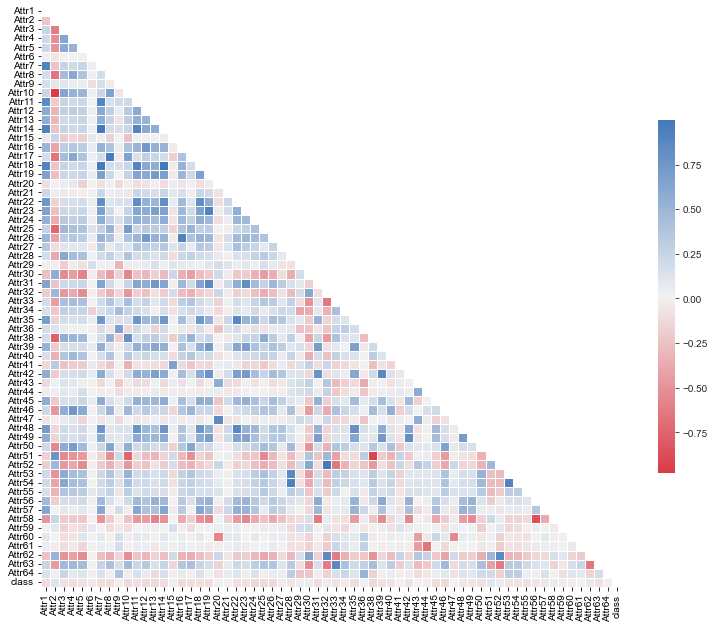

In [34]:
#Check Correlation matrix of mean imputed data
corr = df_mean_imputed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(13, 13))
sns.set_style(style="white")
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,           #corr > 0.8 | corr < -0.8
            square=True, linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            ax= ax , 
            xticklabels = df_mean_imputed.columns.tolist(),
            yticklabels = df_mean_imputed.columns.tolist()) 
           

<AxesSubplot:>

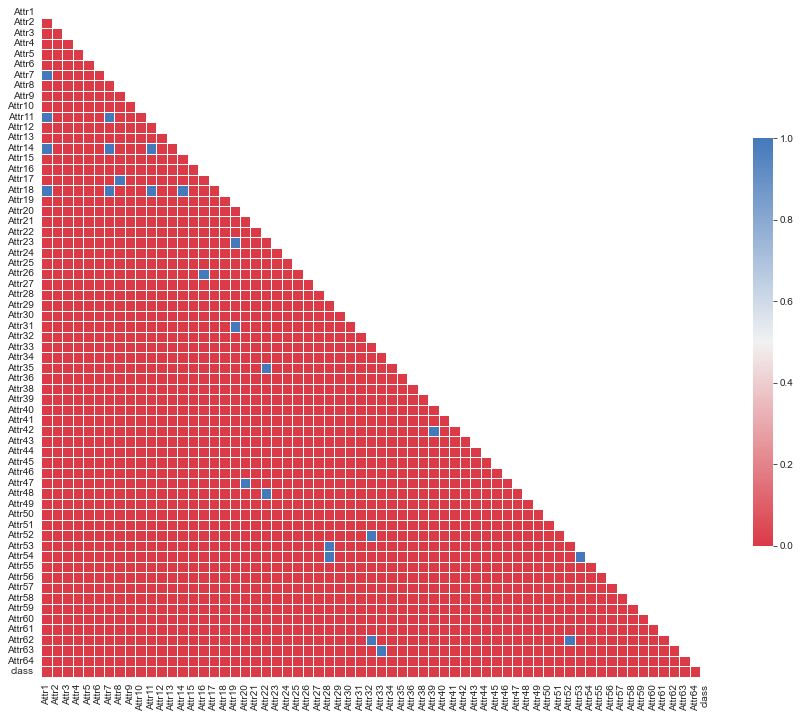

In [35]:
#Check Correlation matrix of median imputed data

corr_2 = df_median_imputed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
sns.set_style(style="white")
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr>0.85, mask=mask,
            cmap=cmap,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            ax= ax,
            xticklabels = df_median_imputed.columns.tolist(),
            yticklabels = df_median_imputed.columns.tolist())

In [ ]:
#Check Correlation matrix of mode imputed data

corr = df_freq_imputed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
sns.set_style(style="white")
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, 
            cmap=cmap,
            square=True, 
            linewidths=.5,
            cbar_kws={"shrink": .5},
            ax= ax,
            xticklabels = df_freq_imputed.columns.tolist(),
            yticklabels = df_freq_imputed.columns.tolist())

Create the correlation groups and finalize the variables according to the groups

In [ ]:
def correlation_group(correlation, percentile):
    correlation_pairs = correlation.unstack()
    high_correlation = correlation_pairs[(correlation_pairs>=percentile)|(correlation_pairs<= -1*percentile)]
    print(high_correlation)

In [ ]:
correlation_group(corr_2 , 0.85)

Columns with attributes 1,7,11,14,22,35,48 show positive correlation(>0.8)
Columns with attributes 3,6,10,25,38,51    show negative correlation(<-0.8)

Attributes positive correlation: 
1. Attr1 -net profit / total assets
2. Attr7 -EBIT(Earnings before interest and taxes) / total assets
3. Attr11-(gross profit + extraordinary items + financial expenses) / total assets
4. Attr14-(gross profit + interest) / total assets
5. Attr22- profit on operating activities / total assets
6. Attr35-profit on sales / total assets
7. Attr48-EBITDA (profit on operating activities - depreciation) / total assets



Attributes negative correlation:
1. Attr3 -working capital / total assets
2. Attr6 -retained earnings / total assets
3. Attr10-equity / total assets
4. Attr25-(equity - share capital) / total assets
5. Attr38-constant capital / total assets
6. Attr51-short-term liabilities / total assets


We take the above attributes in a new dataframe

In [ ]:
# Create new data frame with variables having high positive correlation
df_positive_relation = df_median_imputed[[1,7,11,14,22,35,38,48, 63]]
df_positive_relation.describe().round(3)

In [ ]:
plt.boxplot(df_positive_relation, labels =df_positive_relation.columns )
plt.show()

In [ ]:
sns.pairplot(df_positive_relation, hue= 63)

In [ ]:
# Create new data frame with variables having high negative correlation
df_negative_relation = df_median_imputed[['Attr3','Attr6','Attr10','Attr25','Attr38','Attr51']]
df_negative_relation.describe().round(3)

In [ ]:
plt.boxplot(df_negative_relation, labels = df_negative_relation.columns )
plt.show()